In [2]:
import os
import sklearn
import numpy as np
import pandas as pd
from numpy import unwrap, diff, abs, angle
import pandas as pd
import seaborn as sns
# import tensorflow as tf
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from sklearn.utils import shuffle
import scipy
from scipy.signal import butter, filtfilt, hilbert
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline
# from tensorflow.keras.models import Sequential
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
# from keras.wrappers.scikit_learn import KerasClassifier
# from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# from tensorflow.keras.layers import Dense,  BatchNormalization, Dropout
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
# import mne
# from mne.preprocessing import ICA
# import pywt
from scipy.stats import skew, kurtosis
from scipy.signal import spectrogram
# from mne.viz import plot_topomap
from scipy.signal import welch
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
# import optuna
from sklearn.datasets import make_classification
from PIL import Image, ImageDraw, ImageFont
from joblib import dump
from scipy.signal import butter, filtfilt, lfilter, lfilter_zi
from sklearn.linear_model import SGDClassifier

#####################################################################################
selected_columns = ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'Po7', 'Oz', 'Po8']
fs=250

####################################################################################
#pre/processing functions

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def denoise_data(df, col_names, n_clusters):
    df_denoised = df.copy()
    for col_name, k in zip(col_names, n_clusters):
        df_denoised[col_name] = pd.to_numeric(df_denoised[col_name], errors='coerce') # Convert column to numeric format
        X = df_denoised.select_dtypes(include=['float64', 'int64']) # Select only numeric columns
        clf = KNeighborsRegressor(n_neighbors=k, weights='uniform') # Fit KNeighborsRegressor
        clf.fit(X.index.values[:, np.newaxis], X[col_name])
        y_pred = clf.predict(X.index.values[:, np.newaxis]) # Predict values 
        df_denoised[col_name] = y_pred
    return df_denoised

def z_score(df, col_names):
    df_standard = df.copy()
    for col in col_names:
        df_standard[col] = (df[col] - df[col].mean()) / df[col].std()
    return df_standard

def custom_detrend(df, col_names):
    df_detrended = df.copy()
    for col in col_names:
        y = df_detrended[col]
        x = np.arange(len(y))
        p = np.polyfit(x, y, 1)
        trend = np.polyval(p, x)
        detrended = y - trend
        df_detrended[col] = detrended
    return df_detrended

def preprocess(df, col_names, n_clusters):
    df_new = df.copy()
    df_new = denoise_data(df, col_names, n_clusters)
    return df_new

def df_to_raw(df, sfreq=250):
    info = mne.create_info(ch_names=list(df.columns), sfreq=sfreq, ch_types=['eeg'] * df.shape[1])
    raw = mne.io.RawArray(df.T.values * 1e-6, info)  # Converting values to Volts from microvolts for MNE
    return raw

def reject_artifacts(df, channel):
    threshold_factor = 3
    median = df[channel].median()
    mad = np.median(np.abs(df[channel] - median))
    spikes = np.abs(df[channel] - median) > threshold_factor * mad
    x = np.arange(len(df[channel]))
    cs = CubicSpline(x[~spikes], df[channel][~spikes]) # Interpolate using Cubic Spline
    interpolated_values = cs(x)
    interpolated_values[spikes] *= 0.01  # Make interpolated values 0.01 times smaller
    # Again Check each interpolated value's difference from median and compare to the threshold
    spike_values = np.abs(interpolated_values - median) > threshold_factor * mad
    interpolated_values[spike_values] *= 0.01 
    spike_values = np.abs(interpolated_values - median) > threshold_factor * mad
    interpolated_values[spike_values] *= 0.01 
    df[channel] = interpolated_values
    return df

#########################################################################################
current_directory = os.getcwd()
patient_data_folder = os.path.join(current_directory, "2-Patient Data")

# print(f"Current directory: {current_directory}")
# print(f"Patient data folder: {patient_data_folder}")

folder_name = input("Please enter the subject name: ")
Report_Number = input("Please enter the reprt number: ")
full_folder_path = os.path.join(patient_data_folder, folder_name)

# root_folder = "2-Patient Data"
sub_folders = ["Pre Evaluation", "Neurofeedback", "Post Evaluation"]
phase = int(input("Enter the phase (0, 1, 2): "))  # Or however you get the phase value
# Determine which sub-folders to use based on the phase
folders_to_use = []
if phase == 0:
    folders_to_use = [sub_folders[0]]  # Just "Pre Evaluation"
elif phase == 1:
    folders_to_use = sub_folders[:2]  # "Pre Evaluation" and "Neurofeedback"
elif phase == 2:
    folders_to_use = [sub_folders[2]]  # 
# print('folders_to_use:', folders_to_use)
# Iterate over each folder to read the csv files

################################################################################################
duration = 40 
raw=[]
event=[]
BP=[]
PP=[]
B=[]
Human_Behavior=[]
eeg_processed=[]
for folder in folders_to_use:
    full_folder_path_ = os.path.join(full_folder_path, folder)
    # print('full_folder_path_', full_folder_path_)
    if os.path.exists(full_folder_path_) and os.path.isdir(full_folder_path_):
        # print(f"Reading from: {full_folder_path_}")
        for file_name in os.listdir(full_folder_path_):
            if file_name.endswith('.csv') and (file_name.startswith('raw_eeg_block') or file_name.startswith('fl_')):
                file_path = os.path.join(full_folder_path_, file_name)
                s_temp = pd.read_csv(file_path, header=None)
                inst = s_temp.iloc[:, 17]
                df_temp = s_temp.iloc[:, :8]
                raw.append(df_temp)
                event.append(inst)
                HB=s_temp.iloc[1750:, 17:21]
                inst = s_temp.iloc[:, 17]
                Human_Behavior.append(HB)
                
                # 1. Band Pass
                raw_bp = np.copy(df_temp)
                for column in range(8):
                    raw_bp[:, column] = butter_bandpass_filter(raw_bp[:, column], lowcut=.4, highcut=40, fs=250) 
                # print('raw_bp.shape', raw_bp.shape)
                
                # 2. Artifact rejection
                BP_artifact_RJ = np.copy(raw_bp)
                for channel in range (8):
                    BP_artifact_RJ= reject_artifacts(pd.DataFrame(BP_artifact_RJ), channel)
                
                # 4. Denoising and other preprocessing
                BP_artifact_RJ.columns = selected_columns
                eeg_df_denoised = preprocess(pd.DataFrame(BP_artifact_RJ), col_names=selected_columns, n_clusters=[10]*len(selected_columns))
                
                #concate the labels to the processed data
                eeg_df_denoised_inst=pd.concat([eeg_df_denoised,inst], axis=1) 
                
                # I preprocessed the whole data in each block, then, split it to the base and the activity signal
                baseline=eeg_df_denoised.iloc[:1750,]
                dd=eeg_df_denoised.iloc[1750:,]
                
                eeg_processed.append(eeg_df_denoised_inst) #processes eeg with instruction containing both base and activity signal
                PP.append(dd)
    else:
        print(f"{full_folder_path_} does not exist")

#baseline rejection
activity_baserejected_with_inst=[]
Total_base_rejected_with_inst=[]
face=[]
scene=[]
EEG=[]
event_=[]
for i in range (len(eeg_processed)):
    pp_data=eeg_processed[i]
    instruction = pp_data.iloc[:, 8]
    baseline = pp_data[pp_data.iloc[:, -1].isin(['b', 'g'])].iloc[:, :-1]
    baseline_avg = baseline.mean()
    non_baseline_data = pp_data[~pp_data.iloc[:, -1].isin(['b', 'g'])]
    inst_activity=non_baseline_data.iloc[:, 8]
    adjusted_non_baseline = non_baseline_data.iloc[:, :-1] - baseline_avg
    concatenated = pd.concat([baseline, adjusted_non_baseline], ignore_index=True)
    pp_data_baseline_rejected= pd.concat([concatenated, instruction], axis=1) #both activity ans base with labels
    
    activity_baseline_rejected_with_inst= pd.concat([adjusted_non_baseline, inst_activity], axis=1)
    activity_baserejected_with_inst.append(activity_baseline_rejected_with_inst) #All the activity data and their labels
    
    Total_base_rejected_with_inst.append(pp_data_baseline_rejected) #All the data and their labels
    
    # splitting the data to face and scene category
    if 'I' in instruction.values or 'O' in instruction.values:
        scene.append(pp_data_baseline_rejected) # has also the base            
    if 'M' in instruction.values or 'F' in instruction.values:
        face.append(pp_data_baseline_rejected)  # has also the base                       
    event_.append(instruction)
     
face_np=np.array(face)
scene_np=np.array(scene)
Total_base_rejected_with_inst_np=np.array(Total_base_rejected_with_inst)

In [3]:
event_np=np.array(event_)
labels=[]
for block in range (len(event_np)):
    mask = (event_np[block, :] == 'b') | (event_np[block, :] == 'g')
    e_b=event_np[block, :]
    label=e_b[~mask]
    print(label)
    labels.append(label)
    

['F' 'F' 'F' ... 'F' 'F' 'F']
['M' 'M' 'M' ... 'M' 'M' 'M']
['O' 'O' 'O' ... 'O' 'O' 'O']
['M' 'M' 'M' ... 'M' 'M' 'M']
['I' 'I' 'I' ... 'I' 'I' 'I']
['F' 'F' 'F' ... 'F' 'F' 'F']
['O' 'O' 'O' ... 'O' 'O' 'O']
['I' 'I' 'I' ... 'I' 'I' 'I']


In [4]:
labels_np=np.array(labels)

label_final=labels_np.reshape(int(labels_np.shape[0]*labels_np.shape[1]/fs), fs)


In [5]:
len(label_final)

320

In [6]:
LLL=[]
for i in range(len(label_final)):
    if 'M' in label_final[i, :] or 'F' in label_final[i, :]:
        LLL.append(0)
    else:
        LLL.append(1)        
lll_np=np.array(LLL) 
# Y=np.squeeze(lll_np[:,0])

In [7]:
Total_base_rejected_with_inst_np=np.array(Total_base_rejected_with_inst)

In [9]:
Total_base_rejected_with_inst_np.shape
face_np.shape

(4, 11750, 9)

baseline_corrected_activity (250, 1)
baseline_corrected_activity (250, 1)
baseline_corrected_activity (250, 1)
baseline_corrected_activity (250, 1)
baseline_corrected_activity (250, 1)
baseline_corrected_activity (250, 1)
baseline_corrected_activity (250, 1)
baseline_corrected_activity (250, 1)
baseline_corrected_activity (250, 1)
baseline_corrected_activity (250, 1)
baseline_corrected_activity (250, 1)
baseline_corrected_activity (250, 1)
baseline_corrected_activity (250, 1)
baseline_corrected_activity (250, 1)
baseline_corrected_activity (250, 1)
baseline_corrected_activity (250, 1)
baseline_corrected_activity (250, 1)
baseline_corrected_activity (250, 1)
baseline_corrected_activity (250, 1)
baseline_corrected_activity (250, 1)
baseline_corrected_activity (250, 1)
baseline_corrected_activity (250, 1)
baseline_corrected_activity (250, 1)
baseline_corrected_activity (250, 1)
baseline_corrected_activity (250, 1)
baseline_corrected_activity (250, 1)
baseline_corrected_activity (250, 1)
b

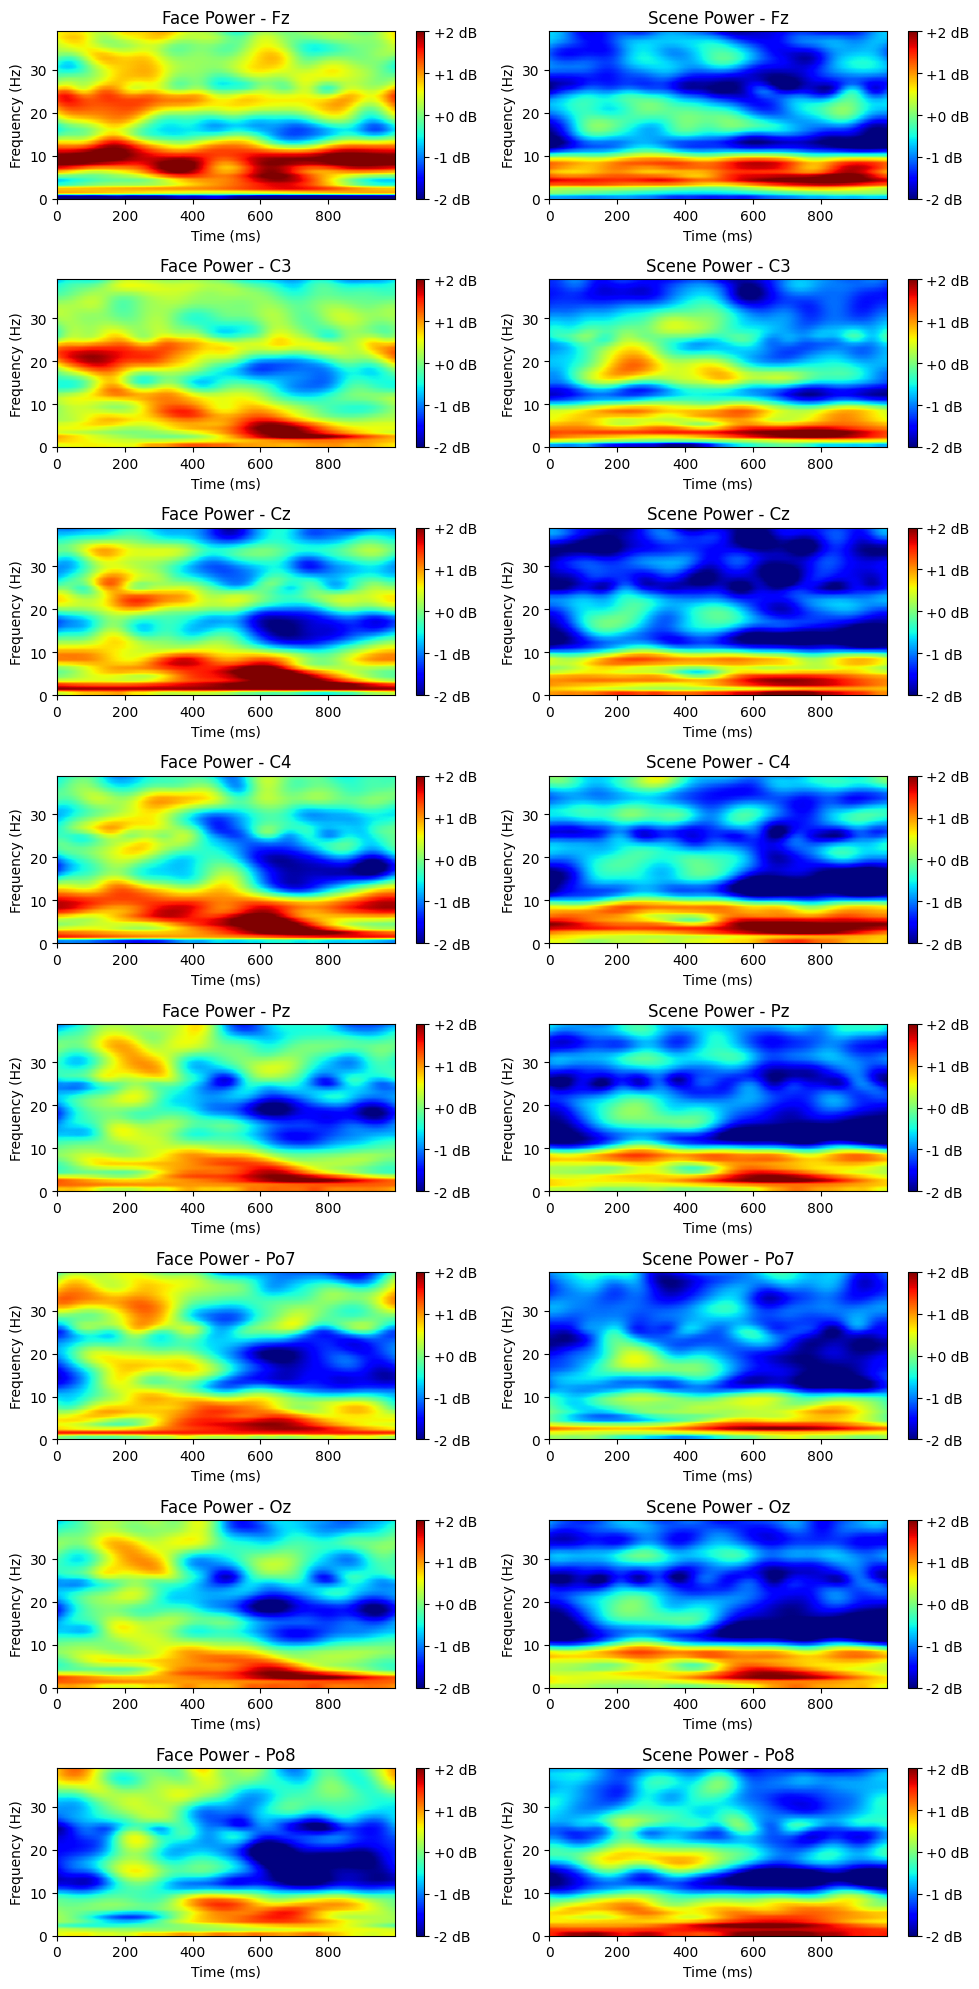

In [130]:
#Wavelet
#functions
def morlet_wavelet(frequency, num_cycles, sampling_rate, duration=2):
    t = np.linspace(-duration/2, duration/2, int(sampling_rate * duration), endpoint=False)
    sine_wave = np.exp(2j * np.pi * frequency * t)
    amplitude_envelope = np.exp(-t**2 * (np.pi * frequency / num_cycles)**2)
    wavelet = sine_wave * amplitude_envelope
    return wavelet

def convolve_with_wavelet(data, wavelet):
    # Ensure data is in 2D form
    if data.ndim == 1:
        data = data[np.newaxis, :]
    n_signal = data.shape[1]
    n_wavelet = len(wavelet)
    n_convolution = n_signal + n_wavelet - 1

    data_fft = np.fft.fft(data, n_convolution, axis=1)
    wavelet_fft = np.fft.fft(wavelet, n_convolution)[np.newaxis, :]
    convolution_result_fft = data_fft * wavelet_fft
    convolution_result = np.fft.ifft(convolution_result_fft, axis=1)
    # Cut the data
    start = (n_wavelet - 1) // 2
    end = start + n_signal
    return convolution_result[:, start:end]

def plot_time_frequency(data, title, ax):
    # Use the provided axes object for plotting
    data_to_plot = 10 * np.log10(data.T + 1e-6)  # Transpose and Log transform of power; add a small constant to avoid log(0)
    img = ax.imshow(data_to_plot, aspect='auto', cmap='jet', origin='lower',
                    extent=[times[0], times[-1], frequencies[0], frequencies[-1]], vmin=-2, vmax=2)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')  # Use fig.colorbar to specify the axes
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Frequency (Hz)')
    ax.set_title(title)
####################################################################################################################################

# Constants
frequencies = np.arange(0, 40, 1)  # 0 to 40 Hz
cycles = np.linspace(1, 10, len(frequencies))  # Variable cycles from 1 to 10
sampling_rate = 250
selected_columns = ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'Po7', 'Oz', 'Po8']

#face
data_f = face_np  
# Initialize a dictionary to store power matrices for each channel
power_matrices_f = {channel: [] for channel in selected_columns}

for channel_idx, channel_name in enumerate(selected_columns):
    power_matrix_f = []
    for freq, cycle in zip(frequencies, cycles):
        power_blocks_base_corrected=[]
        for i in range (len(data_f)): #12
            data_f_i_np= data_f[i]
            data_f_i_np_t=np.transpose(data_f_i_np)

            # Extract one channel
            data_f_i_t = data_f_i_np_t[channel_idx, :]  # Trials are on the second dimension
            data_f_i_inst = data_f_i_np_t[8, :]
            wavelet = morlet_wavelet(freq, cycle, sampling_rate)
            convolution = convolve_with_wavelet(data_f_i_t , wavelet)    
            power = np.abs(convolution)**2

            data_f_i_inst_2d = data_f_i_inst[np.newaxis, :]
            power_with_inst=np.concatenate([power,data_f_i_inst_2d], axis=0)
            power_with_inst_t=np.transpose(power_with_inst)
            mask = (power_with_inst_t[:, 1] == 'b') | (power_with_inst_t[:, 1] == 'g')
            base_l= power_with_inst_t[mask]
            base= base_l[:, :-1]
            # print(base.shape)
            mean_base= np.mean(base_l[:, :-1], axis=0)
            # print('mean_base', mean_base)
            
            epoch_size = 250
            epochs_base = []
            for start in range(0, len(base), epoch_size):
                end = start + epoch_size
                if end <= len(base):
                    epochs_base.append(base[start:end])
                else:
                    epochs_base.append(base[start])
                epochs_base_np=np.array(epochs_base)
            # print('epochs_base_np.shape', epochs_base_np.shape)
            
            # Calculate the mean across the first dimension, excluding the last column
            mean_epochs_base = np.mean(epochs_base_np, axis=0)

            first_200 = mean_epochs_base
            mean_base_200=np.mean(first_200, axis=0)
            
            # last_50 = mean_epochs_base[200:]
            
            activity = power_with_inst_t[~mask]
            
            epoch_size = 250
            epochs = []
            for start in range(0, len(activity), epoch_size):
                end = start + epoch_size
                if end <= len(activity):
                    epochs.append(activity[start:end, :-1])
                else:
                    epochs.append(activity[start:,:-1])
                epochs_np=np.array(epochs)
            # print(epochs_np.shape)
            
            # Calculate the mean across the first dimension, excluding the last column
            activity_mean_epochs = np.mean(epochs_np, axis=0)
            # activity_mean_epochs_concat_base=np.concatenate([last_50,activity_mean_epochs], axis=0)
            # print('activity_mean_epochs_concat_base', activity_mean_epochs_concat_base.shape) #activity_mean_epochs_concat_base (300, 1)
            
            baseline_corrected_activity=activity_mean_epochs/mean_base_200
            print('baseline_corrected_activity', baseline_corrected_activity.shape) #baseline_corrected_activity (300, 1)
            
            power_blocks_base_corrected.append(baseline_corrected_activity)
            # power_blocks_base_corrected_np= np.array(power_blocks_base_corrected)
        power_blocks_base_corrected_np_mean_f=np.mean(power_blocks_base_corrected, axis=0)
        # print('power_blocks_base_corrected_np_mean', power_blocks_base_corrected_np_mean_f.shape)
        power_matrices_f[channel_name].append(power_blocks_base_corrected_np_mean_f)
        power_matrix_f.append(power_blocks_base_corrected_np_mean_f)
        power_matrix_np_f=np.array(power_matrix_f)
        # print('power_matrix_np', power_matrix_np_f.shape)

#scene
data_s = scene_np  
power_matrices_s = {channel: [] for channel in selected_columns}

for channel_idx, channel_name in enumerate(selected_columns):
    power_matrix_s = []
    for freq, cycle in zip(frequencies, cycles):
        power_blocks_base_corrected=[]
        for i in range (len(data_s)): #12
            data_s_i_np= data_s[i]
            data_s_i_np_t=np.transpose(data_s_i_np)

            data_s_i_t = data_s_i_np_t[channel_idx, :]  # Trials are on the second dimension
            data_s_i_inst = data_s_i_np_t[8, :]
            wavelet = morlet_wavelet(freq, cycle, sampling_rate)
            convolution = convolve_with_wavelet(data_s_i_t , wavelet)    
            power = np.abs(convolution)**2

            data_s_i_inst_2d = data_s_i_inst[np.newaxis, :]
            power_with_inst=np.concatenate([power,data_s_i_inst_2d], axis=0)
            power_with_inst_t=np.transpose(power_with_inst)
            mask = (power_with_inst_t[:, 1] == 'b') | (power_with_inst_t[:, 1] == 'g')
            base_l= power_with_inst_t[mask]
            base= base_l[:, :-1]
            # print(base.shape)
            mean_base= np.mean(base_l[:, :-1], axis=0)
            # print('mean_base', mean_base)
            
            epoch_size = 250
            epochs_base = []
            for start in range(0, len(base), epoch_size):
                end = start + epoch_size
                if end <= len(base):
                    epochs_base.append(base[start:end])
                else:
                    epochs_base.append(base[start])
                epochs_base_np=np.array(epochs_base)
            # print('epochs_base_np.shape', epochs_base_np.shape)
            
            mean_epochs_base = np.mean(epochs_base_np, axis=0)

            first_200 = mean_epochs_base
            mean_base_200=np.mean(first_200, axis=0)
            
            # last_50 = mean_epochs_base[200:]
            
            activity = power_with_inst_t[~mask]
            
            epoch_size = 250
            epochs = []
            for start in range(0, len(activity), epoch_size):
                end = start + epoch_size
                if end <= len(activity):
                    epochs.append(activity[start:end, :-1])
                else:
                    epochs.append(activity[start:,:-1])
                epochs_np=np.array(epochs)
            # print(epochs_np.shape)
            
            activity_mean_epochs = np.mean(epochs_np, axis=0)
            # activity_mean_epochs_concat_base=np.concatenate([last_50,activity_mean_epochs], axis=0)
            # print('activity_mean_epochs_concat_base', activity_mean_epochs_concat_base.shape) #activity_mean_epochs_concat_base (300, 1)
            
            baseline_corrected_activity=activity_mean_epochs/mean_base_200
            # print('baseline_corrected_activity', baseline_corrected_activity.shape) #baseline_corrected_activity (300, 1)
            
            power_blocks_base_corrected.append(baseline_corrected_activity)
        power_blocks_base_corrected_np_mean_s=np.mean(power_blocks_base_corrected, axis=0)
        # print('power_blocks_base_corrected_np_mean', power_blocks_base_corrected_np_mean_s.shape)
        power_matrices_s[channel_name].append(power_blocks_base_corrected_np_mean_s)
        power_matrix_s.append(power_blocks_base_corrected_np_mean_s)
        power_matrix_np_s=np.array(power_matrix_s)
        # print('power_matrix_np', power_matrix_np_s.shape)
        
#Save as csv       
for channel, power_data in power_matrices_f.items():
    # Convert the list of arrays into a 2D array
    power_matrix = np.concatenate(power_data, axis=1)  # Concatenate along the second axis
    df = pd.DataFrame(power_matrix)
    df.to_csv(f'face_power_matrix_{channel}.csv', index=False)

for channel, power_data in power_matrices_s.items():
    power_matrix = np.concatenate(power_data, axis=1)  # Concatenate along the second axis
    df = pd.DataFrame(power_matrix)
    df.to_csv(f'scene_power_matrix_{channel}.csv', index=False)

#Extract the tops        
top_20_per_channel_s = {}
top_20_per_channel_f = {}

for channel in selected_columns:
    # Flattened data for both classes
    flattened_data_s = []
    flattened_data_f = []

    # Process for power_matrices_s
    for freq_idx, matrix in enumerate(power_matrices_s[channel]):
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                flattened_data_s.append((matrix[i, j], freq_idx, i, j))

    # Process for power_matrices_f
    for freq_idx, matrix in enumerate(power_matrices_f[channel]):
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                flattened_data_f.append((matrix[i, j], freq_idx, i, j))

    # Sort and select top 20 for power_matrices_s
    flattened_data_s.sort(key=lambda x: x[0], reverse=True)
    top_20_per_channel_s[channel] = flattened_data_s[:10]

    # Sort and select top 20 for power_matrices_f
    flattened_data_f.sort(key=lambda x: x[0], reverse=True)
    top_20_per_channel_f[channel] = flattened_data_f[:10]
    
# Calculate the sampling interval
sampling_interval = 1 / 250  
times = np.arange(0, 1, step=sampling_interval)
times = times * 1000  

#plots
n_channels = 8
fig, axs = plt.subplots(n_channels, 2, figsize=(10, 20))  # Adjust figsize as needed

for i, channel in enumerate(selected_columns):
    # Load from CSV
    df_face = pd.read_csv(f'face_power_matrix_{channel}.csv')
    df_scene = pd.read_csv(f'scene_power_matrix_{channel}.csv')

    # Convert DataFrame to numpy array
    face_power_matrix = df_face.to_numpy()
    scene_power_matrix = df_scene.to_numpy()

    # Use the data from the 50th sample point to 300th
    face_power_matrix_reduced = face_power_matrix
    scene_power_matrix_reduced = scene_power_matrix

    # Plot the results for face and scene
    plot_time_frequency(face_power_matrix_reduced, f'Face Power - {channel}', axs[i, 0])
    plot_time_frequency(scene_power_matrix_reduced, f'Scene Power - {channel}', axs[i, 1])
plt.tight_layout()
plt.show()

In [140]:
combined_freq_time_locations = {}

# Gather all unique channels from both dictionaries
all_channels = set(top_20_per_channel_f) | set(top_20_per_channel_s)

# Iterate over the union of channels
for channel in all_channels:
    # Initialize an empty list to hold the combined data
    combined_freq_time_locations[channel] = []

    # Check if the channel is in the face dictionary
    if channel in top_20_per_channel_f:
        combined_freq_time_locations[channel].extend(
            [(freq, time) for _, freq, time, _ in top_20_per_channel_f[channel]]
        )

    # Check if the channel is in the scene dictionary
    if channel in top_20_per_channel_s:
        combined_freq_time_locations[channel].extend(
            [(freq, time) for _, freq, time, _ in top_20_per_channel_s[channel]]
        )

In [141]:
combined_freq_time_locations

{'C3': [(2, 179),
  (2, 180),
  (2, 178),
  (2, 181),
  (2, 177),
  (4, 161),
  (4, 160),
  (4, 162),
  (2, 182),
  (2, 176),
  (3, 195),
  (3, 196),
  (3, 194),
  (3, 197),
  (3, 193),
  (3, 198),
  (3, 192),
  (3, 199),
  (3, 191),
  (3, 200)],
 'Cz': [(2, 177),
  (2, 178),
  (2, 176),
  (2, 179),
  (2, 175),
  (2, 180),
  (2, 174),
  (2, 181),
  (2, 173),
  (2, 182),
  (0, 185),
  (0, 184),
  (0, 183),
  (0, 186),
  (0, 182),
  (0, 181),
  (0, 180),
  (0, 187),
  (0, 179),
  (0, 178)],
 'Po7': [(3, 157),
  (3, 158),
  (3, 156),
  (3, 159),
  (3, 155),
  (3, 160),
  (3, 154),
  (3, 161),
  (3, 153),
  (3, 162),
  (2, 166),
  (2, 167),
  (2, 165),
  (2, 168),
  (2, 164),
  (2, 169),
  (2, 163),
  (2, 170),
  (2, 162),
  (2, 171)],
 'Oz': [(2, 183),
  (2, 182),
  (2, 184),
  (2, 181),
  (2, 185),
  (2, 180),
  (2, 186),
  (2, 179),
  (2, 187),
  (2, 178),
  (2, 168),
  (2, 169),
  (2, 167),
  (2, 170),
  (2, 166),
  (2, 171),
  (2, 165),
  (2, 172),
  (2, 164),
  (2, 173)],
 'Po8': [(5

(50, 8)
(50, 8)
(50, 8)


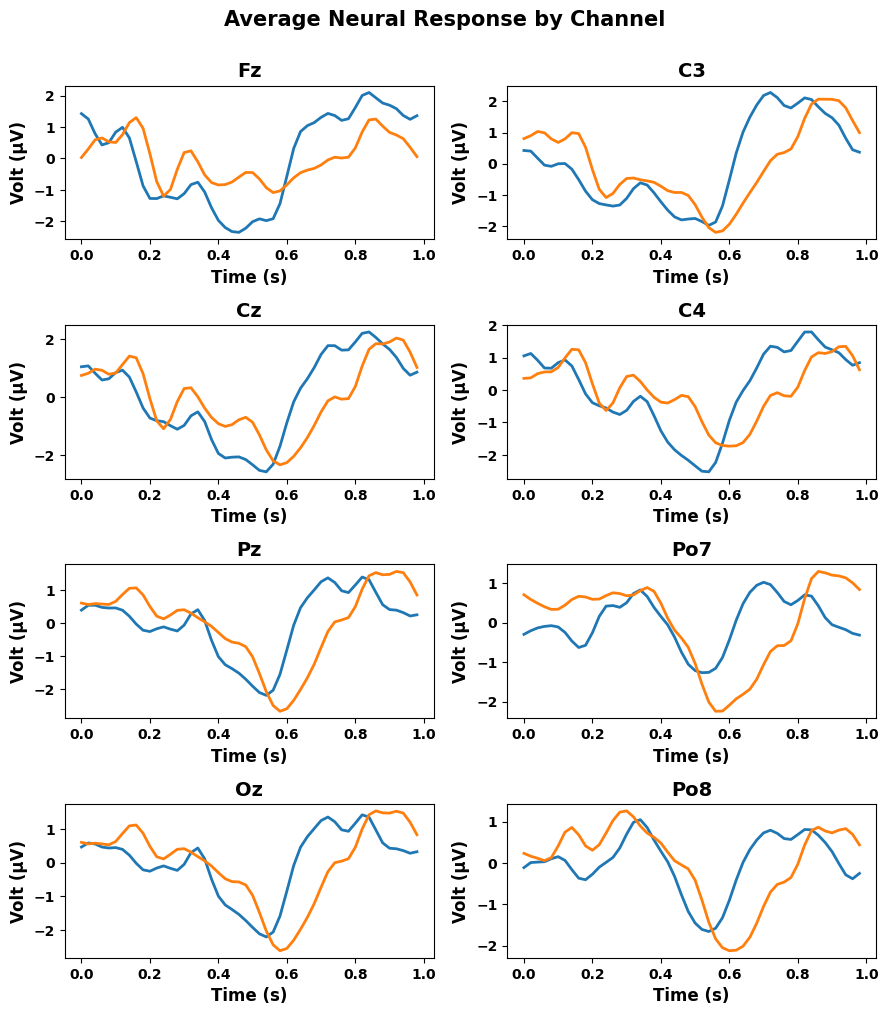

In [6]:
#ERP
# Band Pass
scene_bp = np.copy(scene_np)
face_bp = np.copy(face_np)
for i in range (len(scene_np)):
    for column in range(8):
        scene_bp[i,:, column] = butter_bandpass_filter(scene_bp[i,:, column], lowcut=0.4, highcut=10, fs=250)
        face_bp[i,:, column] = butter_bandpass_filter(face_bp[i,:, column], lowcut=0.4, highcut=10, fs=250)        
#Scene
data = scene_bp 
# Initialize a dictionary to store power matrices for each channel
ERP_s = {channel: [] for channel in selected_columns}
Base_s={channel: [] for channel in selected_columns}

for channel_idx, channel_name in enumerate(selected_columns):
    blocks_erp_acticity = []
    blocks_erp_base=[]
    for i in range (len(data)): 
        data_erp= data[i]
        data_erp_t=np.transpose(data_erp)
        data_erp_inst = data_erp_t[8, :]
        # Extract one channel
        data_i_erp_t = data_erp_t[channel_idx, :] # Trials are on the second dimension
        data_i_erp_inst=np.vstack((data_i_erp_t, data_erp_inst))
        # print(data_i_erp_inst.shape)
        mask = (data_i_erp_inst[1, :] == 'b') | (data_i_erp_inst[1, :] == 'g')
        
        base_i= data_i_erp_inst[:, mask]
        base_i_data= base_i[0, :]
        
        activity_i= data_i_erp_inst[:,~mask]
        activity_i_data= activity_i[0, :]
        # print(activity_i_data.shape[0])
        
        activity_i_downsample=activity_i_data.reshape(int(activity_i_data.shape[0]/250),50,5)
        base_i_downsample=base_i_data.reshape(int(base_i_data.shape[0]/250),50,5)
        
        activity_i_mean=activity_i_downsample.mean(axis=2)
        base_i_mean=base_i_downsample.mean(axis=2)
        
        block_acticity=activity_i_mean.mean(axis=0)
        block_base=base_i_mean.mean(axis=0)
        # print( block_acticity.shape, block_base.shape)
        blocks_erp_acticity.append(block_acticity)
        blocks_erp_acticity_mean=np.mean(blocks_erp_acticity, axis=0)
        blocks_erp_base.append(block_base)
        blocks_erp_base_mean=np.mean(blocks_erp_base, axis=0)
        # print(len(blocks_erp_acticity_mean))
    ERP_s[channel_name].append(blocks_erp_acticity_mean)
    Base_s[channel_name].append(blocks_erp_base_mean)
    
#Face
data = face_bp 

ERP_f = {channel: [] for channel in selected_columns}
Base_f={channel: [] for channel in selected_columns}

for channel_idx, channel_name in enumerate(selected_columns):
    blocks_erp_acticity = []
    blocks_erp_base=[]
    for i in range (len(data)): 
        data_erp= data[i]
        data_erp_t=np.transpose(data_erp)
        data_erp_inst = data_erp_t[8, :]
        data_i_erp_t = data_erp_t[channel_idx, :] 
        data_i_erp_inst=np.vstack((data_i_erp_t, data_erp_inst))
        mask = (data_i_erp_inst[1, :] == 'b') | (data_i_erp_inst[1, :] == 'g')
        
        base_i= data_i_erp_inst[:, mask]
        base_i_data= base_i[0, :]
        
        activity_i= data_i_erp_inst[:,~mask]
        activity_i_data= activity_i[0, :]
        
        activity_i_downsample=activity_i_data.reshape(int(activity_i_data.shape[0]/250),50,5)
        base_i_downsample=base_i_data.reshape(int(base_i_data.shape[0]/250),50,5)
        
        activity_i_mean=activity_i_downsample.mean(axis=2)
        base_i_mean=base_i_downsample.mean(axis=2)
        
        block_acticity=activity_i_mean.mean(axis=0)
        block_base=base_i_mean.mean(axis=0)
        blocks_erp_acticity.append(block_acticity)
        blocks_erp_acticity_mean=np.mean(blocks_erp_acticity, axis=0)
        blocks_erp_base.append(block_base)
        blocks_erp_base_mean=np.mean(blocks_erp_base, axis=0)
    ERP_f[channel_name].append(blocks_erp_acticity_mean)
    Base_f[channel_name].append(blocks_erp_base_mean)
    
array_face = np.array(list(ERP_f.values()))

squeezed_array_face = np.squeeze(array_face, axis=1).T
print(squeezed_array_face.shape)

array_scene = np.array(list(ERP_s.values()))
squeezed_array_scene = np.squeeze(array_scene, axis=1).T
print(squeezed_array_scene.shape)

# Convert the dictionary values to NumPy arrays
array1 = np.array(list(Base_f.values()))
array2 = np.array(list(Base_s.values()))

# Calculate the element-wise average
average_array_base = (array1 + array2) / 2
average_array_base_squeeze=np.squeeze(average_array_base , axis=1).T

print(average_array_base_squeeze.shape)

time_list = []
for n in range(50):
    time = (n*5)/(250)
    time_list.append(time)


plt.figure(figsize=(9,12))
plt.suptitle('Average Neural Response by Channel', y=1.002, fontsize=15, weight='bold') 

for channel in range(8):
    plt.subplot(5,2, channel + 1)  
    plt.plot(time_list, squeezed_array_face[:, channel], label=f'Scene', linewidth=2)
    plt.plot(time_list, squeezed_array_scene[:, channel], label=f'Face', linewidth=2)
    # plt.plot(time_list, average_array_base_squeeze[:, channel], label=f'Base', linewidth=2)
    plt.title(selected_columns[channel], fontsize=14, weight='bold')  # Adding the channel name as the title with bold and bigger font
    
    # Bigger and bold x and y axis labels
    plt.xlabel('Time (s)', fontsize=12, weight='bold')               
    plt.ylabel('Volt (µV)', fontsize=12, weight='bold')      

    # Bigger and bold x and y axis tick labels
    plt.xticks(fontsize=10, weight='bold')
    plt.yticks(fontsize=10, weight='bold')

    # plt.legend(fontsize=10)

plt.tight_layout()
plt.show()

In [373]:
#Envelop Hilbert
from scipy.signal import hilbert

fs=250
frequency_bands = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 14),
    'beta': (14, 30),
    'gamma': (30, 40)}

baseline_epochs=7
epoch_length=250

#face
data_s=face_np
hilbert_f=[]
# f=[]
for channel_idx, channel_name in enumerate(selected_columns):
    hil_block=[]
    # f_block=[]
    for block_index in range(len(scene_np)):
        f_band_env=[]
        f_band=[]
        for band, (lowcut, highcut) in frequency_bands.items():
            data = data_s[block_index, :, channel_idx]
            data_band= butter_bandpass_filter(data, lowcut, highcut, fs, order=5)
            envelope = np.abs(hilbert(data_band))
            # Split into epochs and calculate mean of activity epochs
            epochs = np.split(envelope,envelope.shape[0] // epoch_length)
            mean_activity_epoch = np.mean(epochs[baseline_epochs:], axis=0)
            
            
            f_band_env.append(mean_activity_epoch)
            # f_band.append(mean_activity_epoch)        
        hil_block.append(f_band_env)   
        # f_block.append(f_band)
    hilbert_f.append(hil_block)
    # f.append(f_block)

hilbert_f_np=np.array(hilbert_f)
# f_np=np.array(f)
print(hilbert_f_np.shape ) #(8, 4, 5, 250)

#scene
data_s=scene_np
hilbert_s=[]
# s=[]
for channel_idx, channel_name in enumerate(selected_columns):
    hil_block=[]
    s_block=[]
    for block_index in range(len(scene_np)):
        s_band_env=[]
        s_band=[]
        for band, (lowcut, highcut) in frequency_bands.items():
            data = data_s[block_index, :, channel_idx]
            data_band= butter_bandpass_filter(data, lowcut, highcut, fs, order=5)
            envelope = np.abs(hilbert(data_band))
            # Split into epochs and calculate mean of activity epochs
            epochs = np.split(envelope,envelope.shape[0] // epoch_length)
            mean_activity_epoch = np.mean(epochs[baseline_epochs:], axis=0)
           
            s_band_env.append(mean_activity_epoch)
            # s_band.append(mean_activity_epoch)        
        hil_block.append(s_band_env)   
        # s_block.append(s_band)
    hilbert_s.append(hil_block)
    # s.append(s_block)

hilbert_s_np_=np.array(hilbert_s)
# s_np=np.array(s)
# # print(hilbert_s_np.shape, s_np.shape ) #(8, 4, 5, 250)

# hilbert_s_np_mean=np.mean(hilbert_s_np, axis=1)
hilbert_f_np_mean=np.mean(hilbert_f_np, axis=1)

# s_np_mean=np.mean(s_np, axis=1)
# f_np_mean=np.mean(f_np, axis=1)

print(hilbert_f_np_mean.shape)

(8, 4, 5, 250)
(8, 5, 250)


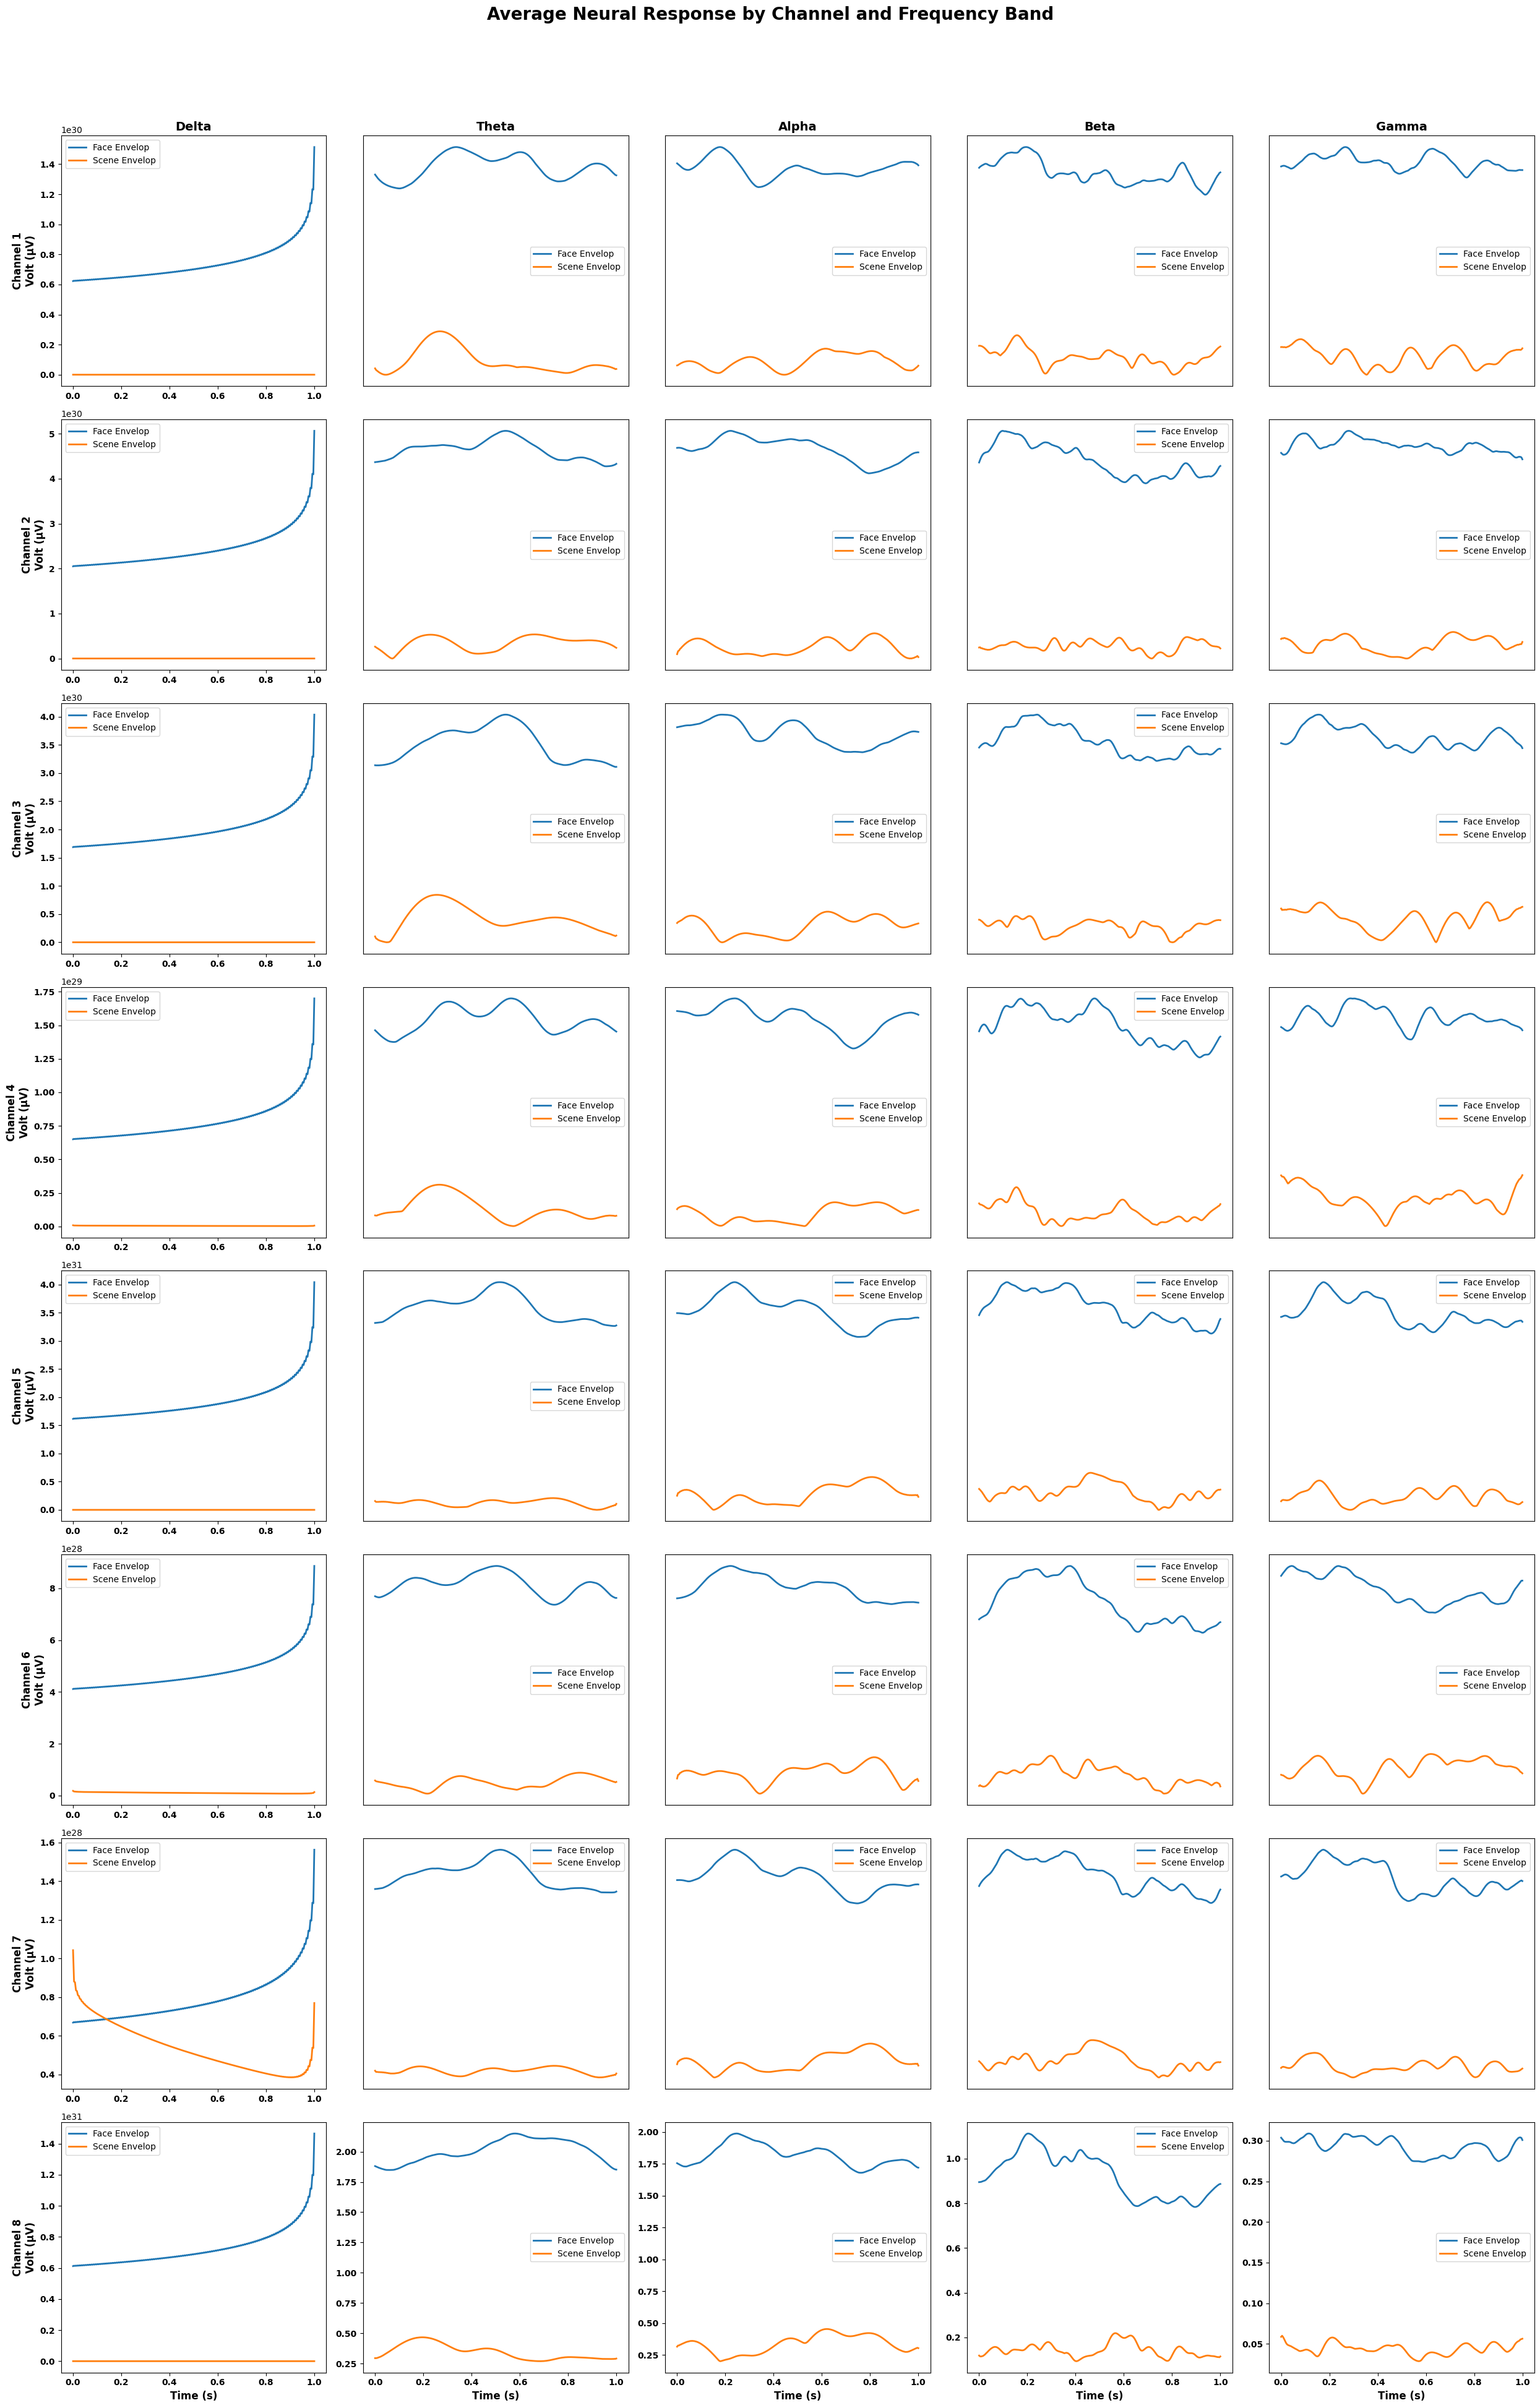

In [374]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming epoch_length is defined and equals 250
epoch_length = 250  
t = np.linspace(0, epoch_length / 250, epoch_length)

# Define the frequency band names for titles
frequency_band_names = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']

# Define a large enough figure size to accommodate 8x5 subplots
plt.figure(figsize=(25, 40))  # Adjust the size as needed
plt.suptitle('Average Neural Response by Channel and Frequency Band', y=1.002, fontsize=20, weight='bold')

# Loop over channels and frequency bands
for channel in range(8):
    for band in range(5):
        # Calculate subplot index
        subplot_idx = channel * 5 + band + 1
        plt.subplot(8, 5, subplot_idx)
        
        # Plot the envelopes and raw signals for each channel and band
        plt.plot(t, hilbert_f_np_mean[channel, band, :], label='Face Envelop', linewidth=2)
        plt.plot(t, hilbert_s_np_mean[channel, band, :], label='Scene Envelop', linewidth=2)
        # plt.plot(t, f_np_mean[channel, band, :], label='Face', linewidth=2)
        # plt.plot(t, s_np_mean[channel, band, :], label='Scene', linewidth=2)
        
        # Set the title for each subplot with channel and frequency band information
        if band == 0:
            plt.ylabel(f'Channel {channel + 1}\nVolt (µV)', fontsize=12, weight='bold')
        
        if channel == 0:
            plt.title(frequency_band_names[band], fontsize=14, weight='bold')
        
        # Only show x label on the bottom row and y label on the first column
        if channel == 7:
            plt.xlabel('Time (s)', fontsize=12, weight='bold')
        
        # Set ticks properties only for the outer plots to avoid clutter
        if channel == 7 or band == 0:
            plt.xticks(fontsize=10, weight='bold')
            plt.yticks(fontsize=10, weight='bold')
        else:
            plt.xticks([])
            plt.yticks([])
        
        # if channel == 0 and band == 0:
        plt.legend(fontsize=10)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0.03, 1, 0.97])

# Show plot
plt.show()


In [166]:
#Feature Extraction
#Wavelet
####################################################################################################################################
# Constants
frequencies = np.arange(0, 40,1)  # 0 to 40 Hz
cycles = np.linspace(1, 10, len(frequencies))  # Variable cycles from 1 to 10
sampling_rate = 250
selected_columns = ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'Po7', 'Oz', 'Po8']

data_T = Total_base_rejected_with_inst_np #shape: (8, 11750, 9)

# Initialize a dictionary to store power matrices for each channel
power_matrices_T = {channel: [] for channel in selected_columns}

for channel_idx, channel_name in enumerate(selected_columns):
    power_matrix_T = []
    for freq, cycle in zip(frequencies, cycles):
        power_blocks_base_corrected=[]
        for i in range (len(data_T)): #8
            data_T_i_np= data_T[i]
            data_T_i_np_t=np.transpose(data_f_i_np)

            # Extract one channel
            data_T_i_t = data_f_i_np_t[channel_idx, :]  # Trials are on the second dimension
            data_T_i_inst = data_f_i_np_t[8, :]
            wavelet = morlet_wavelet(freq, cycle, sampling_rate)
            convolution = convolve_with_wavelet(data_T_i_t , wavelet)    
            power = np.abs(convolution)**2

            data_T_i_inst_2d = data_T_i_inst[np.newaxis, :]
            power_with_inst=np.concatenate([power,data_T_i_inst_2d], axis=0)
            power_with_inst_t=np.transpose(power_with_inst)
            mask = (power_with_inst_t[:, 1] == 'b') | (power_with_inst_t[:, 1] == 'g')
            base_l= power_with_inst_t[mask]
            base= base_l[:, :-1]
            # print(base.shape)
            # mean_base= np.mean(base_l[:, :-1], axis=0)
            # print('mean_base', mean_base)
            
            epoch_size = 250
            epochs_base = []
            for start in range(0, len(base), epoch_size):
                end = start + epoch_size
                if end <= len(base):
                    epochs_base.append(base[start:end])
                else:
                    epochs_base.append(base[start])
                epochs_base_np=np.array(epochs_base)
            # print('epochs_base_np.shape', epochs_base_np.shape)
            
            # Calculate the mean across the first dimension, excluding the last column
            mean_epochs_base = np.mean(epochs_base_np, axis=0)
            # print('mean_epochs_base.shape', mean_epochs_base.shape)
            
            first_200 = mean_epochs_base
            mean_base_200=np.mean(first_200, axis=0)
            
            # last_50 = mean_epochs_base[200:]
            # last_50_reshaped=last_50.reshape(1,last_50.shape[0], last_50.shape[1])
            # repeated_last_50 = np.repeat(last_50_reshaped, 40, axis=0)
            # print('repeated_last_50', repeated_last_50.shape)
            # # print('last_50', last_50.shape)
            activity = power_with_inst_t[~mask]
            
            epoch_size = 250
            epochs = []
            for start in range(0, len(activity), epoch_size):
                end = start + epoch_size
                if end <= len(activity):
                    epochs.append(activity[start:end, :-1])
                else:
                    epochs.append(activity[start:,:-1])
                epochs_np=np.array(epochs)
            # print('epochs_np', epochs_np.shape)
            
            # Calculate the mean across the first dimension, excluding the last column
            activity_mean_epochs = epochs_np #np.mean(epochs_np, axis=0)
            # print('activity_mean_epochs', activity_mean_epochs.shape)
            # activity_mean_epochs_concat_base=np.concatenate([repeated_last_50,activity_mean_epochs], axis=1)
            # print('activity_mean_epochs_concat_base', activity_mean_epochs_concat_base.shape) #activity_mean_epochs_concat_base (300, 1)
            
            baseline_corrected_activity=activity_mean_epochs/mean_base_200
            # print('baseline_corrected_activity', baseline_corrected_activity.shape) #baseline_corrected_activity (300, 1)
            
            power_blocks_base_corrected.append(baseline_corrected_activity)
            # power_blocks_base_corrected_np= np.array(power_blocks_base_corrected)
        # power_blocks_base_corrected_np_mean_T=np.mean(power_blocks_base_corrected, axis=0)
        # print('power_blocks_base_corrected_np_mean', power_blocks_base_corrected_np_mean_f.shape)
        power_matrices_T[channel_name].append(power_blocks_base_corrected)
        # power_matrix_T.append(power_blocks_base_corrected)
        # power_matrix_np_T=np.array(power_matrix_T)
        # print('power_matrix_np', power_matrix_np_f.shape)
        
# power_matrices_T_np=np.array(power_matrices_T['Po8'])
# power_matrices_T_np.shape #(20, 8, 40, 250, 1)

# Initialize a list to store the 2D arrays for each input
input_matrices = []

# List of channel names, assuming the order matches the channels in combined_freq_time_locations
channel_names = ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'Po7', 'Oz', 'Po8'] 

# Iterate over each block and epoch
for block in range(8):
    for epoch in range(40):
        # Initialize an empty 2D array for this input
        current_input_matrix = np.zeros((8, 20))

        # Iterate over each channel to extract features
        for idx, channel in enumerate(channel_names):
            channel_array = np.array(power_matrices_T[channel])
            locations = combined_freq_time_locations[channel]

            # Extract the 20 features for this channel and input
            channel_features = [channel_array[freq_idx, block, epoch, time_idx, 0] for freq_idx, time_idx in locations]
            current_input_matrix[idx, :] = channel_features

        # Append the 2D array for this input to the list
        input_matrices.append(current_input_matrix)

# Stack the 2D arrays to form a 3D matrix
wavelet_feature_matrix = np.stack(input_matrices)
# feature_matrix has the shape (320, 8, 20)
###############################################################################################################################################################


In [338]:
GG=np.array(power_matrices_T['C3'])
GG.shape

(40, 8, 40, 250, 1)

In [351]:
type(power_matrices_T)
eeg_data=power_matrices_T

In [ ]:
import numpy as np
import scipy.stats

# Assuming 'eeg_data' contains your EEG data and 'channel_names' is a list of channel names
# The structure of eeg_data should be aligned with channel_names

features = {}

for idx, channel_name in enumerate(channel_names):
    # Access the data for this channel
    # The following line is an example and needs to be adjusted to your data structure
    channel_data_ = eeg_data[channel_name]  # Assuming each channel's data is indexed by 'idx'
    channel_data=np.array(channel_data_)
    print(channel_data.shape)



    # Calculate statistical features
    mean = np.mean(channel_data)
    std_dev = np.std(channel_data)
    median = np.median(channel_data)
    skewness = scipy.stats.skew(channel_data.flatten())
    kurtosis = scipy.stats.kurtosis(channel_data.flatten())
    max_val = np.max(channel_data)
    min_val = np.min(channel_data)

    # Store the features with channel name as key
    features[channel_name] = {
        'mean': mean,
        'std_dev': std_dev,
        'median': median,
        'skewness': skewness,
        'kurtosis': kurtosis,
        'max_val': max_val,
        'min_val': min_val
    }


In [507]:
#Envelop Hilbert feature
import numpy as np
import scipy
from scipy.signal import hilbert, find_peaks, welch
from scipy.stats import skew, kurtosis

fs=250
frequency_bands = {
    'theta': (4, 8),
    'alpha': (8, 14),
    'beta': (14, 30),
    'gamma': (30, 40)} #'delta': (0.5, 4),

baseline_epochs=7
epoch_length=250

#Hilbert feature
data_s= data_T #shape: (8, 11750, 9)
hilbert_T=[]
for channel_idx, channel_name in enumerate(selected_columns):
    hil_block=[]
    for block_index in range(len(data_T)):
        f_band_env=[]
        for band, (lowcut, highcut) in frequency_bands.items():
            data = data_s[block_index, :, channel_idx]
            data_band= butter_bandpass_filter(data, lowcut, highcut, fs, order=5)
            envelope = np.abs(hilbert(data_band))
            
            # Split into epochs and calculate mean of activity epochs
            epochs = np.split(envelope,envelope.shape[0] // epoch_length)
            # mean_activity_epoch = np.mean(epochs[baseline_epochs:], axis=0)
            
            f_band_env.append(epochs)       
        hil_block.append(f_band_env)   
    hilbert_T.append(hil_block)
hilbert_T_np=np.array(hilbert_T)
print(hilbert_T_np.shape) #(8, 8, 5, 47, 250)

# Initialize the list for the feature matrix
hilbert_feature_matrices = []

# Iterate over blocks and the last 40 epochs
for block in range(8):
    for epoch in range(7, 47):  # Last 40 epochs
        # Initialize a 2D array for this input's features: 8 channels x (5 frequency bands * 6 features)
        input_features = np.zeros((8, 4 * 1))

        # Iterate over each channel and frequency band
        for channel in range(8):
            for freq_band in range(4):
                # Extract the envelope for the current channel, block, frequency band, and epoch
                envelope = hilbert_T_np[channel, block, freq_band, epoch, :]

                # Compute the features
                mean_env = np.mean(envelope)
                # median_env = np.median(envelope)
                # std_env = np.std(envelope)
                # skewness_env = skew(envelope)
                # kurtosis_env = kurtosis(envelope)
                # energy = np.sum(envelope**2)

                # Combine the features
                features = np.array([mean_env])

                # Place the features in the corresponding location in the input_features array
                input_features[channel, freq_band * 1:(freq_band + 1) *1] = features

        # Append this input's features to the feature matrix list
        hilbert_feature_matrices.append(input_features)

# Convert the list of feature matrices to a 3D NumPy array
hilbert_feature_matrix = np.array(hilbert_feature_matrices) # shape (320, 8, 30)
print('hilbert_feature_matrix',hilbert_feature_matrix.shape)


(8, 8, 4, 47, 250)
hilbert_feature_matrix (320, 8, 4)


In [508]:
hilbert_feature_matrix[2,3,:]

array([2.59522769, 2.73251426, 0.95080662, 0.22093393])

In [216]:
#ERP feature
# Band Pass
data_bp = np.copy(data_T)
for i in range (len(scene_np)):
    for column in range(8):
        data_bp[i,:, column] = butter_bandpass_filter(scene_bp[i,:, column], lowcut=0.4, highcut=10, fs=250)
#Scene
data = data_bp 
data_reshaped_erp=data.reshape(data.shape[0], int(data.shape[1]/250),250, 9)

c=(50/1000)
P100_window = (int(80*c),int(120*c))
N200_window = (int(180*c),int(220*c))
P300_window = (int(280*c),int(320*c)) 
N600_window = (int(580*c), int(620*c))


def extract_ERP_features(epoch):
    N200_region= epoch[N200_window[0]:N200_window[1]]
    P300_region = epoch[P300_window[0]:P300_window[1]]
    N600_region = epoch[N600_window[0]:N600_window[1]]
    P100_region = epoch[P100_window[0]:P100_window[1]]
    
    P100_amplitude = np.max(P100_region)
    P100_mean_amplitude = np.mean(P100_region)
    P100_latency = np.argmin(P100_region) + P100_window[0]
    
    N200_amplitude= np.min(N200_region)
    N200_mean_amplitude = np.mean(N200_region)
    N200_latency = np.argmax(N200_region) + N200_window[0]
    
    P300_amplitude = np.max(P300_region)
    P300_mean_amplitude = np.mean(P300_region)
    P300_latency = np.argmax(P300_region) + P300_window[0]
    
    N600_amplitude = np.min(N600_region)
    N600_mean_amplitude = np.mean(N600_region)
    N600_latency = np.argmin(N600_region) + N600_window[0]

    return [
        P100_mean_amplitude,
        N200_mean_amplitude, 
        P300_mean_amplitude, 
        N600_mean_amplitude,     
    ]



In [215]:
# Iterate over each block and epoch
input_matrices=[]
for block in range(8):
    for epoch in range(7,47):
        # Initialize an empty 2D array for this input
        current_input_matrix = np.zeros((8, 4))

        # Iterate over each channel to extract features
        for channel in range(8):
            channel_array = data_reshaped_erp[block,epoch,:,channel]
            # Extract the 20 features for this channel and input
            channel_features = extract_ERP_features(channel_array)
            current_input_matrix[channel, :] = channel_features
        # Append the 2D array for this input to the list
        input_matrices.append(current_input_matrix)
ERP_matrices_np=np.array(input_matrices)

In [474]:
combined_features = np.concatenate([hilbert_feature_matrix], axis=2)  #hilbert_feature_matrix, ERP_matrices_np,wavelet_feature_matrix
combined_features.shape

(320, 8, 24)

In [495]:
################################################################################################################
#Input to the classifier
# label=labels.reshape(int(labels.shape[0]/fs), fs)
# Y=np.squeeze(label[:,0])
# print('Y.shape', Y.shape)
# denoised_reshaped = pp_sig_event_no_event_column.reshape(int(pp_sig_event_no_event_column.shape[0]/250), 250, 8)
# print('denoised_reshaped.shape',denoised_reshaped.shape)

mlp_data=combined_features.reshape(combined_features.shape[0], combined_features.shape[1]*combined_features.shape[2])
print('mlp_data.shape', mlp_data.shape)

af_mlp=mlp_data
Y_mlp=lll_np

print(af_mlp.shape, Y_mlp.shape)
af_mlp, Y_mlp= shuffle(af_mlp, Y_mlp)
print(af_mlp.shape, Y_mlp.shape)

# # Balance the dataset
# oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
# X_resampled_mlp, y_resampled_mlp = oversampler.fit_resample(af_mlp, Y_mlp)
# X_resampled_mlp= X_resampled_mlp.astype(np.float32)
# y_resampled_mlp = y_resampled_mlp.astype(np.int32)
# print('X_resampled_mlp.shape', X_resampled_mlp.shape)

#Split to train and test
X_train, X_test, y_train, y_test = train_test_split(af_mlp,Y_mlp, test_size=0.1, random_state=42)
#Split to train and validation
X_train_mlp, X_validation_mlp, y_train_mlp, y_validation_mlp = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

########################################################################################################################################



mlp_data.shape (320, 192)
(320, 192) (320,)
(320, 192) (320,)


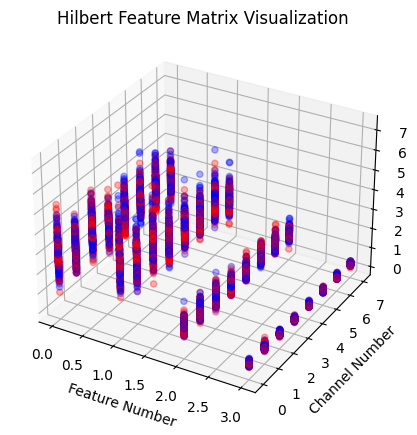

In [513]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Assuming 'hilbert_feature_matrix' and 'Y_mlp' are defined as before
# hilbert_feature_matrix = ... # Your Hilbert feature matrix (320 samples, 8 channels, 24 features)
# Y_mlp = ...  # Your label array (320 samples)

# Plotting
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')

# Half the number of samples
half_samples = hilbert_feature_matrix.shape[0] 

# Plot each sample
for i in range(half_samples):
    # Extracting the 8x4 matrix of features for each sample (considering only first 4 features)
    Z = hilbert_feature_matrix[i, :, :4]  # Adjust the number of features here
    X, Y = np.meshgrid(np.arange(Z.shape[1]), np.arange(Z.shape[0]))
    
    # Flatten X, Y, Z for scatter plot
    X_flat = X.flatten()
    Y_flat = Y.flatten()
    Z_flat = Z.flatten()

    # Determine the color based on the label
    color = 'blue' if Y_mlp[i] == 0 else 'red'

    ax.scatter(X_flat, Y_flat, Z_flat, color=color, alpha=0.3)

ax.set_xlabel('Feature Number')
ax.set_ylabel('Channel Number')
ax.set_zlabel('Feature Value')
ax.set_title('Hilbert Feature Matrix Visualization')
plt.show()


In [492]:
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
import numpy as np

# Create an RBF sampler
rbf_feature = RBFSampler(gamma=.05, random_state=1)

# Create an SGD classifier
sgd_clf = SGDClassifier(loss='log', max_iter=1000, tol=1e-3)

# Create a pipeline
rbf_sgd_clf = make_pipeline(rbf_feature, sgd_clf)

# Number of folds for k-fold cross-validation
n_folds = 5

# Create k-fold object
kf = KFold(n_splits=n_folds)

# Prepare to collect accuracies
accuracies = []


X=af_mlp
y=Y_mlp
# Iterate over each split
for train_index, val_index in kf.split(X):
    # Split the data
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Fit the model on the training data
    rbf_sgd_clf.fit(X_train, y_train)

    # Evaluate the model on the validation data
    accuracy = rbf_sgd_clf.score(X_val, y_val)
    accuracies.append(accuracy)
    print(f"Fold Accuracy: {accuracy}")

# Calculate average accuracy over all folds
average_accuracy = np.mean(accuracies)
print(f"Average Accuracy: {average_accuracy}")


Fold Accuracy: 0.59375
Fold Accuracy: 0.578125
Fold Accuracy: 0.5625
Fold Accuracy: 0.5625
Fold Accuracy: 0.5625
Average Accuracy: 0.571875


d:\11-software\Python3.8\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
d:\11-software\Python3.8\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
d:\11-software\Python3.8\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
d:\11-software\Python3.8\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
d:\11-software\Python3.8\lib\sit

In [485]:
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline

# Create an RBF sampler
rbf_feature = RBFSampler(gamma=.05, random_state=1)

# Create an SGD classifier
sgd_clf = SGDClassifier(loss='log', max_iter=1000, tol=1e-3)

# Create a pipeline
rbf_sgd_clf = make_pipeline(rbf_feature, sgd_clf)

# Fit the model
rbf_sgd_clf.fit(X_train_mlp, y_train_mlp)

# Evaluate the model
accuracy = rbf_sgd_clf.score(X_validation_mlp, y_validation_mlp)
print(f"Accuracy: {accuracy}")



Accuracy: 0.5344827586206896


d:\11-software\Python3.8\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


In [486]:
# Evaluate the model
accuracy = rbf_sgd_clf.score(X_test, y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.59375


In [455]:
# Now you can use predict_proba to get probability estimates
probabilities = rbf_sgd_clf.predict_proba(X_test)
print(probabilities)

[[9.98301008e-01 1.69899189e-03]
 [7.75722704e-01 2.24277296e-01]
 [7.30079969e-01 2.69920031e-01]
 [8.31942347e-01 1.68057653e-01]
 [9.85274517e-01 1.47254825e-02]
 [9.94930869e-01 5.06913054e-03]
 [9.70362558e-01 2.96374417e-02]
 [8.08719763e-01 1.91280237e-01]
 [9.71288770e-01 2.87112301e-02]
 [6.77206387e-01 3.22793613e-01]
 [9.83662970e-01 1.63370301e-02]
 [6.73724208e-01 3.26275792e-01]
 [9.87672104e-01 1.23278965e-02]
 [9.39798127e-04 9.99060202e-01]
 [7.27636893e-01 2.72363107e-01]
 [7.50507914e-01 2.49492086e-01]
 [9.92287613e-01 7.71238732e-03]
 [9.51472793e-01 4.85272070e-02]
 [2.26767276e-02 9.77323272e-01]
 [5.17053266e-03 9.94829467e-01]
 [9.97085656e-01 2.91434384e-03]
 [3.73411671e-02 9.62658833e-01]
 [7.61104623e-01 2.38895377e-01]
 [9.66094847e-01 3.39051534e-02]
 [9.96007969e-01 3.99203052e-03]
 [9.41614097e-01 5.83859034e-02]
 [9.44608994e-01 5.53910057e-02]
 [5.96876381e-01 4.03123619e-01]
 [3.55518366e-01 6.44481634e-01]
 [3.70194366e-02 9.62980563e-01]
 [5.671671

In [ ]:
# import numpy as np
# import scipy
# from scipy.signal import hilbert, find_peaks, welch
# from scipy.stats import skew, kurtosis

# # Example signal
# fs = 1000  # Sampling frequency
# t = np.linspace(0, 1, fs, False)  # Time array
# signal = np.sin(2 * np.pi * 5 * t) + 0.5 * np.sin(2 * np.pi * 10 * t)  # Example signal

# # Hilbert Transform to get the envelope
# analytic_signal = hilbert(signal)
# envelope = np.abs(analytic_signal)

# # Statistical Features
# mean_env = np.mean(envelope)
# median_env = np.median(envelope)
# std_env = np.std(envelope)
# skewness_env = skew(envelope)
# kurtosis_env = kurtosis(envelope)

# # Peak Features
# peaks, _ = find_peaks(envelope)
# peak_heights = envelope[peaks]
# peak_intervals = np.diff(peaks) / fs

# # Energy Features
# energy = np.sum(envelope**2)

# # Frequency Domain Features
# f, Pxx = welch(envelope, fs=fs)
# dominant_frequency = f[np.argmax(Pxx)]
# spectral_entropy = -np.sum(Pxx * np.log2(Pxx + 1e-8))

# # Temporal Features (Rate of Change)
# rate_of_change = np.diff(envelope) * fs

# # Output the features
# features = {
#     "Mean": mean_env,
#     "Median": median_env,
#     "Standard Deviation": std_env,
#     "Skewness": skewness_env,
#     "Kurtosis": kurtosis_env,
#     "Peak Heights": peak_heights,
#     "Peak Intervals": peak_intervals,
#     "Energy": energy,
#     "Dominant Frequency": dominant_frequency,
#     "Spectral Entropy": spectral_entropy,
#     "Rate of Change": rate_of_change
# }

# for key, value in features.items():
#     print(f"{key}: {value}")

# # Note: The rate_of_change array will be one element shorter than the original envelope array
